<a href="https://colab.research.google.com/github/kellybrower/mlg/blob/master/Exercise_1_Warmup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo](https://uploads-ssl.webflow.com/5a72b3a09e04c7000168f4de/5ce6005b22f44fde8ced717c_MD%20Horizontal.png)

# Octavian.ai machine learning on graphs course

Welcome to our summer course on graph ML.

This course is primarily exercise based - you'll learn through reading and writing code, and answering the questions throughout these exercises.

[Join our Discord](https://discord.gg/a2Z82Te) to chat with fellow enthusiasts about this exercise and give us feedback to direct the next one.

## Exercise 1, the warm-up

This is the first installment of our course! Thanks for joining us. 

In this exercise, I'll introduce you to:

- [Tensorflow 2.0](https://www.tensorflow.org/alpha)
- Python 3
- Working with simple graph data
- Classifying nodes in a graph

There will be questions, areas to write code and also some discussion of choices made in crafting this.


### The problem we'll work with

In this exercise we will predict the political orientation (left learning vs right leaning) of a blog based on which other blogs it has links to/from.

Our graph nodes will be blogs (e.g. a single domain with many pages) and the edges will be the links that blog has to other blogs (from any of its pages).

This is a pretty neat dataset, from the paper [The Political Blogosphere and the 2004 U.S. Election: Divided They Blog](http://www.ramb.ethz.ch/CDstore/www2005-ws/workshop/wf10/AdamicGlanceBlogWWW.pdf). 

You can [download graph data here](http://konect.uni-koblenz.de/networks/moreno_blogs), however the solution template below will do that for you automatically.



### Solution approach

This is a fascinating problem as you can take many different approaches to it, from hand-crafted heuristics to complex machine learning.

For the purposes of this warm-up, we’ll take a simple approach. It won’t be as capable as other approaches (e.g. its test accuracy will be sub-optimal).

We’ll learn a function that determines a node’s political orientation L given its set of neighbours (represented as an unordered list of their orientations).

The function will be a simple machine learning function. You'll write a simple dense layer for the first version, and then are encouraged to try other functions to see if they perform better.

---

## Get the data

The first step in most machine learning experiments is to get hold of the required data.

Universität Koblenz-Landau kindly have hosted this data. First let's download it and unarchive it:

In [0]:
# Get data

!wget http://konect.uni-koblenz.de/downloads/tsv/moreno_blogs.tar.bz2
!tar xfvj moreno_blogs.tar.bz2

--2019-06-11 04:28:04--  http://konect.uni-koblenz.de/downloads/tsv/moreno_blogs.tar.bz2
Resolving konect.uni-koblenz.de (konect.uni-koblenz.de)... 141.26.208.254
Connecting to konect.uni-koblenz.de (konect.uni-koblenz.de)|141.26.208.254|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49912 (49K) [application/octet-stream]
Saving to: ‘moreno_blogs.tar.bz2.4’

moreno_blogs.tar.bz 100%[===================>]  48.74K   225KB/s    in 0.2s    

2019-06-11 04:28:05 (225 KB/s) - ‘moreno_blogs.tar.bz2.4’ saved [49912/49912]

moreno_blogs.tar.bz2	moreno_blogs.tar.bz2.2	moreno_blogs.tar.bz2.4
moreno_blogs.tar.bz2.1	moreno_blogs.tar.bz2.3	sample_data
moreno_blogs/
moreno_blogs/out.moreno_blogs_blogs
moreno_blogs/meta.moreno_blogs_blogs
moreno_blogs/README.moreno_blogs
moreno_blogs/ent.moreno_blogs_blogs.blog.orientation


Next, let's get the python libraries we'll need for the code:

In [0]:
# Set up Python environment
!pip install -q tensorflow==2.0.0-alpha0

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

Let's also define a couple of constants for later on:

In [0]:
# Define constants

# How many neighhbors to consider when predicting a node's label
# The fact that we fix this is quite interesting, more discussion
# of this later.
FIXED_NEIGHBOR_SIZE = 10

# The batch size we'll bucket our data into before running the machine
# learning functions
BATCH_SIZE = 32

And now for processing the data.

There are two files we'll process from the download:


*   `out.moreno_blogs_blogs` Graph edges, expressed as pairs of node indices, where the first index is 1
*  `ent.moreno_blogs_blogs.blog.orientation` The label (left-leaning or right-leaning) of each blog, expressed as one label per line, with the first line being the label for blog index 1


To get the data ready for machine learning we need to represent it as training examples for the network. Our example format will be:
* Input data: A list of neighbor labels, each represented as one-hot vectors left-leaning=[1,0] or right-learning[0,1]. 
* Expected output: A label, represented as an integer left-leaning=0 or right-leaning=1

The machine learning function will try to learn a mapping between the input data and expected output.

Once we've created the list of examples, we split them into training data (90% of the total) and test data (10% of the total).

In [0]:
# Load the data

import random
import csv
from sklearn.model_selection import train_test_split
from collections import Counter
import itertools


def label_to_int(label):
  '''
    An incredibly simple token embedding. Translates binary tokens into int
  '''
  if label == 'left-leaning':
    return 0
  else:
    return 1

def label_to_vec(label):
  '''
    An incredibly simple token embedding. Translates binary tokens into one-hot vector
  '''
  if label == 'left-leaning':
    return [1,0]
  else:
    return [0,1]

def load_data():
  '''
    Transform data into the format needed for our training
  '''
  
  edges = []
  
  with open('/content/moreno_blogs/out.moreno_blogs_blogs') as f:
    reader = csv.reader(f, delimiter=' ')
    for i in reader:
      if i[0] != "%":
        edges.append( (int(i[0])-1, int(i[1])-1) )
      
  labels = []
  
  with open('/content/moreno_blogs/ent.moreno_blogs_blogs.blog.orientation') as f:
    reader = csv.reader(f, delimiter=' ')
    for i in reader:
      labels.append(i[0])
      
      
  # Dataset for test and training
  # (where L is a left/right label)
  
  # X are inputs: [L, L, L, L] list of neighbor labels
  X = []
  
  # y are labels
  y = []
  
  for (node_id, label) in enumerate(labels):
    neighbors = set()
    for (v1, v2) in edges:
      if v1 == node_id:
        neighbors.add(v2)
      if v2 == node_id:
        neighbors.add(v1)
        
    try:
      neighbors.remove(node_id)
    except:
      # It's fine, we're just guarding against self-reference that would make this
      # exercise a bit easier
      pass
        
    neighbor_labels = [label_to_vec(labels[i]) for i in neighbors]
    random.shuffle(neighbor_labels)
    
    X.append(neighbor_labels)
    y.append(label_to_int(label))
    
  return X, y
    

X, y = load_data()

print("Data statistics")
print("Number of data-points", len(X))
print("Average number of neighbors", np.average([len(i) for i in X]))
print("Max number of neighbors", np.max([len(i) for i in X]))
print("Min number of neighbors", np.min([len(i) for i in X]))
print("Distribution of labels", Counter(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print()
print("Number of training examples", len(X_train))
print("Distribution of labels", Counter(y_train))
print("Example: ", X_train[90], " has label ", y_train[90])

print()
print("Number of test examples", len(X_test))
print("Distribution of labels", Counter(y_test))
print("Example: ", X_test[0], " has label ", y_test[0])

Data statistics
Number of data-points 1224
Average number of neighbors 27.312091503267975
Max number of neighbors 351
Min number of neighbors 1
Distribution of labels Counter({1: 636, 0: 588})

Number of training examples 1040
Distribution of labels Counter({1: 542, 0: 498})
Example:  [[0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0]]  has label  1

Number of test examples 184
Distribution of labels Counter({1: 94, 0: 90})
Example:  [[1, 0], [1, 0]]  has label  0


Now that we have our data represented as python lists, we will package it up for TensorFlow into [Dataset](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset) instances.

### Fixed sized data

As alluded to earlier, TensorFlow strongly prefers our data to be of fixed size. In our input data we include a list of each nodes' neighbors. A node can have any number of neighbors, from zero to every other node in the graph. This is certainly not a fixed sized list!

To solve this, here I define a function to force the lists to be an exact size - either by padding them or cropping them. This is bad for a few reasons:
* It throws away useful information if there are too many edges
* It creates extra arithmetic work for the machine learning to do when there are too few edges

**QUESTIONS FOR KEEN STUDENTS:** 
* Why does TensorFlow prefer fixed sized data? 
* How can we feed variable length data into TensorFlow and what are the downsides? 
* How much of a problem is it if we discard some edges?
* How much of a problem is it if we use a really `high target_len`?
* What other approaches could we take to solving this problem? 

Note that this is a somewhat unsolved problem in Graph Machine Learning, you won't find a simple answer. In considering the trade-offs and roots of this problem, you'll be better equiped to develop successful systems.

### Datasets

We use the TensorFlow Dataset object for easy data manipulation. This also lets us:
* Split the data into [mini-batches](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/)
* Shuffle the data (the default is that it'll be reshuffled each epoch)

In [0]:

def fix_size_of_list(data, target_len=FIXED_NEIGHBOR_SIZE):
  '''
  This function highlights one of the central challenges of graph data:
  it is naturally variable sized and frameworks like TensorFlow want
  fixed sized tensor data.
  
  Our simplistic solution is to fix the size - we chop it down if too large, or
  zero pad it if too small.
  '''
  
  delta = len(data) - target_len
  
  if delta >= 0:
    return data[0:target_len]
  else:
    return np.pad(data, [(0, -delta), (0,0)], mode='constant', constant_values=0)


# Create TensorFlow dataset objects ready for training and evaluation

## Training data

X_train_fixed = [fix_size_of_list(i) for i in X_train]

dataset_train = tf.data.Dataset.from_tensor_slices(( X_train_fixed , y_train))
dataset_train = dataset_train.batch(BATCH_SIZE)
dataset_train = dataset_train.shuffle(BATCH_SIZE * 10)

## Test data

X_test_fixed = [fix_size_of_list(i) for i in X_test]

dataset_test = tf.data.Dataset.from_tensor_slices(( X_test_fixed , y_test))
dataset_test = dataset_test.batch(BATCH_SIZE)

# The machine learning model

Welcome to the exciting part - we've got our data in order and now we get to engineer a model to solve it.

We'll use the [Keras API](https://keras.io) here as it's simple and quick to get running. 

There are a couple of steps to our model:

1. Define a sequence of layers
2. Compile the model to use our desired loss function, optimizer and metrics
3. Train the model to fit our training data
4. Evaluate the model on our test data

The goal is to get as high a test accuracy as possible (e.g. how well the model predicts labels on the test data after training on the training data).

Our model takes a list of neighbor labels, and outputs the probablilty of each possible label (`left-leaning` or `right-leaning`) as a vector of width two (since it represents a [one-hot-vector](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). We use a [softmax](http://cs231n.github.io/linear-classify/#softmax) activation to push the vector into looking like a probability distribution (e.g. it sums to 1.0)

**EXERCISE**: Add a [dense layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) 

In [0]:
model = keras.Sequential([
  layers.Input(shape=[FIXED_NEIGHBOR_SIZE, 2]),
  layers.Flatten(),
  layers.Dense(2),
  layers.Softmax()
])

model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 42        
_________________________________________________________________
softmax_1 (Softmax)          (None, 2)                 0         
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


Now the model's written, we can train and test it:

In [0]:

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Training:")
history = model.fit(dataset_train, epochs=13, verbose=1)

print("\n\nFinal test accuracy:")

results = model.evaluate(dataset_test)

for l, v in zip(model.metrics_names, results):
  print(l, v)



Training:
Epoch 1/13
33/33 [==============================] - 0s 9ms/step - loss: 0.9694 - accuracy: 0.2654
Epoch 2/13
33/33 [==============================] - 0s 2ms/step - loss: 0.7800 - accuracy: 0.5356
Epoch 3/13
33/33 [==============================] - 0s 2ms/step - loss: 0.6432 - accuracy: 0.6462
Epoch 4/13
33/33 [==============================] - 0s 1ms/step - loss: 0.5468 - accuracy: 0.6933
Epoch 5/13
33/33 [==============================] - 0s 2ms/step - loss: 0.4781 - accuracy: 0.7481
Epoch 6/13
33/33 [==============================] - 0s 2ms/step - loss: 0.4277 - accuracy: 0.7837
Epoch 7/13
33/33 [==============================] - 0s 2ms/step - loss: 0.3895 - accuracy: 0.7856
Epoch 8/13
33/33 [==============================] - 0s 2ms/step - loss: 0.3598 - accuracy: 0.8115
Epoch 9/13
33/33 [==============================] - 0s 2ms/step - loss: 0.3361 - accuracy: 0.8519
Epoch 10/13
33/33 [==============================] - 0s 1ms/step - loss: 0.3167 - accuracy: 0.8663
Epoch 11/

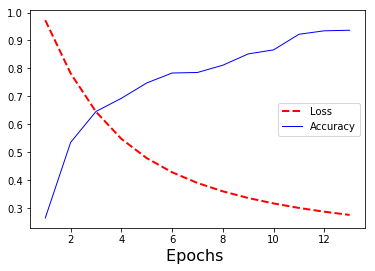

In [0]:
import matplotlib.pyplot as plt 

training_loss = history.history['loss']
training_acc = history.history['accuracy']
#test_loss = history.history['val_loss']

epoch_count = range(1, len(training_loss)+1)

#plt.figure(figsize=[8,6])
line1 = plt.plot(epoch_count, training_loss, 'r--', linewidth=2.0)
line2 = plt.plot(epoch_count, training_acc, 'b-', linewidth=1.0)
plt.xlabel('Epochs ', fontsize=16)
plt.legend(['Loss', 'Accuracy'])
plt.show()



## Exercise

The first half of the exercise is simply to understand and think about the code shared above. If this is as far as you get, that’s ok - there will be more exercises later and more “fill in the code blanks”.

The second half is to try altering the code and see how your changes perform. The important thing is trying out things and thinking about how they perform, this is the core skill of research.

### Things to try

- Complete the code above, run the notebook and see it work!
- What happens if you increase the number of training epochs? Decrease them? ([hint](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f))
- What is the worst test accuracy this model could achieve?
- See what test accuracy the code achieves - does it seem good or bad?
- Come up with an explanation of why it achieves this test accuracy
- Try to improve the test accuracy. These may or may not work, record in the experiment log below your findings.
  - Try editing the fixed size of the neighbor list
  - Try more dense layers
  - Try a 1d convolution across the neighbors’ labels, then sum that
  - Try including the neighbors’ neighbors in the dataset and see if that helps
  - Try including the adjacency matrix and performing multiple iterations of graph-convolution
  - Try a harder variation of this problem: Remove x% of the neighbor labels and see how well your solution categorizes the nodes.
  
  
  ### Experiment log
  
  * Experiment tried e.g. I added a second dense layer
    * Result e.g. Test accuracy was XX%
    * Observations e.g. I saw the loss plateux in epoch X


